In [1]:
import mxnet as mx
from mxnet import init, gluon, nd, autograd, image
from mxnet.gluon import nn
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/cifar10'

In [2]:
def load_cifar(route = data_dir+'/cifar-10-batches-py'):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    return train_pic, train_label, test_pic, test_label

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(test_data, net, ctx):
    acc = 0.
    for data, label in test_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc = acc + accuracy(output, label)
    return acc / len(test_data)

def augment(data, auglist):
    data = nd.pad(data, pad_width=(0,0,0,0,2,2,2,2),mode='constant',constant_value=0)
    data = nd.transpose(data, (0,2,3,1))
    temp = []
    for d in data:
        for aug in auglist:
            d = aug(d)
        temp.append(d)
    data = nd.stack(*temp)
    data = nd.transpose(data, (0,3,1,2))
    return data

In [3]:
class Residual(nn.Block):
    def __init__(self, channels, same_shape=True, equal=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        self.equal = equal
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.bn1 = nn.BatchNorm()
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1, strides=strides)
            self.bn2 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            if (not same_shape) or (not equal):
                self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=strides)
    def forward(self, x):
        out = self.conv1(nd.relu(self.bn1(x)))
        out = self.conv2(nd.relu(self.bn2(out)))
        if (not self.same_shape) or (not self.equal):
            x = self.conv3(x)
        return out + x

class wrn(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(wrn, self).__init__(**kwargs)
        with self.name_scope(): 
            net = self.net = nn.Sequential()
            net.add(nn.Conv2D(channels=16, kernel_size=3, strides=1, padding=1))
            net.add(Residual(channels=16*8, equal=False))
            net.add(Residual(channels=16*8), Residual(channels=16*8))            
            net.add(Residual(channels=32*8, same_shape=False))
            net.add(Residual(channels=32*8), Residual(channels=32*8))
            net.add(Residual(channels=64*8, same_shape=False))
            net.add(Residual(channels=64*8), Residual(channels=64*8))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
    def forward(self, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
        return out

In [4]:
train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_pic = np.transpose(train_pic.astype('float32')/255, (0,2,3,1))
test_pic = np.transpose(test_pic.astype('float32')/255, (0,2,3,1))
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
for i in range(3):
    train_pic[:,:,:,i] = (train_pic[:,:,:,i] - mean[i])/std[i]
    test_pic[:,:,:,i] = (test_pic[:,:,:,i] - mean[i])/std[i]
train_pic = np.transpose(train_pic, (0,3,1,2))
test_pic = np.transpose(test_pic, (0,3,1,2))
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label.astype('float32')), 
                                   batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label.astype('float32')), 
                                  batch_size, shuffle=False)

In [5]:
aug_train = image.CreateAugmenter(data_shape=(3, 32, 32), rand_crop=True, rand_mirror=True)

net = wrn(10)
net.initialize(ctx=ctx, init=init.Xavier())
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 5e-4})

0 loss:1.4546 tracc:0.4655 teacc:0.4839 time:125.999
10 loss:0.4043 tracc:0.8603 teacc:0.7781 time:126.190
20 loss:0.3309 tracc:0.8867 teacc:0.8370 time:126.081
30 loss:0.2994 tracc:0.8967 teacc:0.8195 time:126.381
40 loss:0.2853 tracc:0.9018 teacc:0.7975 time:126.242
50 loss:0.2816 tracc:0.9039 teacc:0.8415 time:126.346
60 loss:0.1360 tracc:0.9563 teacc:0.9397 time:126.314
70 loss:0.0405 tracc:0.9874 teacc:0.9302 time:126.328
80 loss:0.0578 tracc:0.9819 teacc:0.9215 time:126.897
90 loss:0.0600 tracc:0.9806 teacc:0.9178 time:126.217
100 loss:0.0499 tracc:0.9837 teacc:0.9241 time:126.278
110 loss:0.0581 tracc:0.9816 teacc:0.9054 time:126.234
120 loss:0.0189 tracc:0.9951 teacc:0.9517 time:126.002
130 loss:0.0023 tracc:0.9999 teacc:0.9552 time:125.890
140 loss:0.0019 tracc:1.0000 teacc:0.9572 time:126.002
150 loss:0.0019 tracc:1.0000 teacc:0.9568 time:125.694
tracc:0.999980 teacc:0.956784


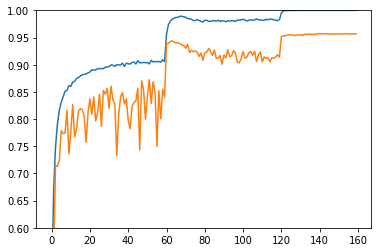

In [6]:
epochs = 160

a, b = [], []
for epoch in range(epochs):
    if epoch == 60:
        trainer.set_learning_rate(0.02)
    if epoch == 120:
        trainer.set_learning_rate(0.004)
    if epoch == 140:
        trainer.set_learning_rate(0.0008)
    train_loss = 0.
    train_acc = 0.
    start = time()
    for data, label in train_data:
        data = augment(data, aug_train).as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(batch_size)
        train_loss = train_loss + nd.mean(l).asscalar()
        train_acc = train_acc + accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    
    if epoch%10 == 0:
        print(epoch, 'loss:%.4f tracc:%.4f teacc:%.4f time:%.3f'%(
            train_loss/len(train_data), train_acc/len(train_data), test_acc, time()-start)) 
    a.append(train_acc/len(train_data))
    b.append(test_acc)

print('tracc:%f teacc:%f'%(train_acc/len(train_data), test_acc))
plt.plot(np.arange(epochs), a, np.arange(epochs), b)
plt.ylim(0.6,1)
plt.show()